# CB03 V1/V2 Comparison (initial)


## Imports

In [104]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import pytz
from pytz import timezone 
import matplotlib.dates as mdates

## Data Log Processing (V1)

In [105]:
# Location of files to be processed
data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\20230825-1013_PT13_CB03_Elev0.76ftNAVD88"

# Initialize an empty DataFrame to store the extracted data
total_data = pd.DataFrame()

# Define the range of data logs to be processed
start_log = 114
end_log = 153

# Join all data together into a Pandas dataframe
for data_log_number in range(start_log, end_log + 1):
    data_log_suffix = f"{data_log_number:00}"
    data_log_filename = f"datalog00{data_log_suffix}.txt"
    file_path = os.path.join(data_location, data_log_filename)

    if os.path.isfile(file_path):
        data = pd.read_csv(file_path, sep=',')
        total_data = pd.concat([total_data, data], ignore_index=True)
    else:
        print(f"File for datalog {data_log_suffix} not found.")

print(total_data)


         rtcDate      rtcTime   VIN      aX      aY       aZ  imu_degC  \
0        rtcDate      rtcTime   VIN      aX      aY       aZ  imu_degC   
1        rtcDate      rtcTime   VIN      aX      aY       aZ  imu_degC   
2     08/25/2023  11:17:27.70  4.47  209.96  330.57  -932.13     42.98   
3     08/25/2023  11:20:53.28  4.68  200.68  321.78  -931.15     44.85   
4     08/25/2023  11:26:53.26  4.70  208.98  329.59  -919.43     37.14   
...          ...          ...   ...     ...     ...      ...       ...   
9637  10/04/2023  14:44:57.88  4.65  -39.55  -31.74 -1000.98      34.5   
9638  10/04/2023  14:50:57.88  4.65  -40.53  -18.55 -1013.18      34.4   
9639  10/04/2023  14:56:57.88  4.66  -48.83  -33.69 -1025.88      34.4   
9640  10/04/2023  15:02:57.88  4.65  -45.41   -2.44 -1003.91     34.31   
9641  10/04/2023  15:08:57.87  4.66  -55.66   -7.32 -1005.37     34.02   

         mbar   degC  count  Unnamed: 10  
0        mbar   degC  count          NaN  
1        mbar   degC  cou

## Data Combination 

In [106]:
# Merge rtcDate and rtcTime into one column
total_data['Date_Time'] = total_data['rtcDate'].astype(str) + " " + total_data['rtcTime'].astype(str)
total_data['Sensor Pressure'] = total_data['mbar']

# print(total_data)

# Drop specified columns from total_data
columns_to_drop = ['rtcDate', 'rtcTime', 'VIN', 'aX', 'aY', 'aZ', 'imu_degC', 'degC', 'count']
total_data = total_data.drop(columns=columns_to_drop)

# Filter rows where 'Reading' is not equal to 'rtcDate rtcTime'
total_data = total_data[total_data['Date_Time'] != 'rtcDate rtcTime']

# Parse the 'Date_Time' column to datetime
total_data['Date_Time'] = pd.to_datetime(total_data['Date_Time'], format='%m/%d/%Y %H:%M:%S.%f')
total_data = total_data.sort_values(by='Date_Time')

# Set Index 
# Set the datetime column as the index
total_data.set_index('Date_Time', inplace=True)

# Make timezone aware
timezone = pytz.timezone('America/New_York')

# Localize the datetime column to Eastern Time
total_data.index = total_data.index.tz_localize('EST')

# Convert to Eastern Daylight Time (EDT)
total_data.index = total_data.index.tz_convert('America/New_York')

pressure_source = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\20230825-1013_PT13_CB03_Elev0.76ftNAVD88\Atmospheric Pressure Data\Atm_commaRemoved_20230824-20231014.csv"

# Read text file into Pandas DataFrame
waterdf = pd.read_csv(pressure_source, sep=',')

# Convert the 'Reading' column to a pandas datetime format if it's not already
waterdf['Reading'] = pd.to_datetime(waterdf['Reading'])

waterdf = waterdf.rename(columns={'Reading' : 'Date_Time'})

# Sort dates and times into ascending order
waterdf = waterdf.sort_values(by='Date_Time')

# Make the 'date_time' column timezone aware by localizing it to EDT
waterdf['Date_Time'] = waterdf['Date_Time'].dt.tz_localize('America/New_York')

# Merge 'total_data' and 'waterdf' DataFrames based on the 'Date_Time' and 'Reading' columns
combined_data = pd.merge_asof(total_data, waterdf, on='Date_Time', direction='nearest')

# Convert 'Value' to a numeric data type (float) if it's not already
combined_data['Value'] = pd.to_numeric(combined_data['Value'], errors='coerce')


# Set 'Date_Time' as the index to enable time-based interpolation
combined_data.set_index('Date_Time', inplace=True)

# Interpolate 'Value' column using time-based interpolation
combined_data['Value'] = combined_data['Value'].interpolate(method='time')

# Filter data for August to October
combined_data = combined_data['2023-08-25':'2023-10-13']

# Format Data
columns_to_drop_2 = ['Unnamed: 10', 'Receive', 'Data Quality', 'mbar']
combined_data = combined_data.drop(columns=columns_to_drop_2)
combined_data = combined_data.rename(columns={'Value' : 'Atmospheric Pressure'})

# Correct for atmospheric pressure (mbar)
combined_data['Pressure from Water'] = combined_data['Sensor Pressure'].astype(float) - combined_data['Atmospheric Pressure'].astype(float)

# Convert mbar water to meters water above sensor (h = P/pg)
# Note that the 100 is converting the mbar to Pascals 
combined_data['Water Depth Above Sensor (meters)'] = ((combined_data['Pressure from Water']) * 100) / (1020 * 9.81)

# Convert from meters water above sensor to meters water above NAVD88
combined_data['Water Elevation NAVD88 (meters NAVD88)'] = combined_data['Water Depth Above Sensor (meters)'] + (.84 / 3.281)

# Convert from meters NAVD88 to ft. NAVD88
combined_data['Water Level (ft. NAVD88)'] = combined_data['Water Elevation NAVD88 (meters NAVD88)'] * 3.281

# Print the final combined and processed DataFrame
display(combined_data)



,Sensor Pressure,Atmospheric Pressure,Unit,Pressure from Water,Water Depth Above Sensor (meters),Water Elevation NAVD88 (meters NAVD88),Water Level (ft. NAVD88)
Date_Time,,,,,,,
2023-08-25 12:17:27.700000-04:00,1010.46,1015.5,mBar,-5.04,-0.050369,0.205651,0.674740
2023-08-25 12:20:53.280000-04:00,1011.62,1015.5,mBar,-3.88,-0.038776,0.217244,0.712776
2023-08-25 12:26:53.260000-04:00,1008.77,1015.6,mBar,-6.83,-0.068258,0.187762,0.616047
2023-08-25 12:32:53.250000-04:00,1007.85,1015.5,mBar,-7.65,-0.076453,0.179567,0.589159
2023-08-25 12:38:53.250000-04:00,1008.31,1015.5,mBar,-7.19,-0.071855,0.184164,0.604242
...,...,...,...,...,...,...,...
2023-10-04 15:44:57.880000-04:00,1052.3,1020.4,mBar,31.90,0.318802,0.574822,1.885990
2023-10-04 15:50:57.880000-04:00,1045.2,1020.4,mBar,24.80,0.247846,0.503866,1.653184
2023-10-04 15:56:57.880000-04:00,1042.15,1020.4,mBar,21.75,0.217365,0.473385,1.553175


## Yacht Basin Water Levels 

In [107]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\20230825-1013_PT13_CB03_Elev0.76ftNAVD88\Yacht Basin Water Levels"

# Read file into a dataframe
file_path = data_location + '\\YB_WLs_CB03.csv'  
yb_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['Receive', 'Data Quality', 'Unit']
yb_waterlevels = yb_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
yb_waterlevels = yb_waterlevels.rename(columns={'Reading' : 'Date_Time', 'Value' : 'Water Level (ft. NAVD88)'})

# Convert the 'Reading' column to a pandas datetime format if it's not already
yb_waterlevels['Date_Time'] = pd.to_datetime(yb_waterlevels['Date_Time'])

# Make the 'date_time' column timezone aware by localizing it to EDT
yb_waterlevels['Date_Time'] = yb_waterlevels['Date_Time'].dt.tz_localize('America/New_York')

# Set Datetime column as index
yb_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
yb_waterlevels = yb_waterlevels.sort_values(by='Date_Time')




yb_waterlevels 

,Water Level (ft. NAVD88)
Date_Time,
2023-08-24 00:06:03-04:00,1.36
2023-08-24 00:14:07-04:00,1.47
2023-08-24 00:26:08-04:00,1.59
2023-08-24 00:36:06-04:00,1.67
2023-08-24 00:54:07-04:00,1.77
...,...
2023-10-14 23:15:06-04:00,1.30
2023-10-14 23:27:03-04:00,1.19
2023-10-14 23:36:08-04:00,1.14


## V2 Water Levels 8/25 to 9/1

In [108]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20230825_20230901.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-08-25 14:02:00-04:00,1.94
2023-08-25 14:08:00-04:00,1.93
2023-08-25 14:14:00-04:00,1.91
2023-08-25 14:20:00-04:00,1.90
2023-08-25 14:26:00-04:00,1.90
...,...
2023-08-31 23:32:00-04:00,2.90
2023-08-31 23:38:00-04:00,2.86
2023-08-31 23:44:00-04:00,2.82


## Plotting 8/25/23 - 9/1/23

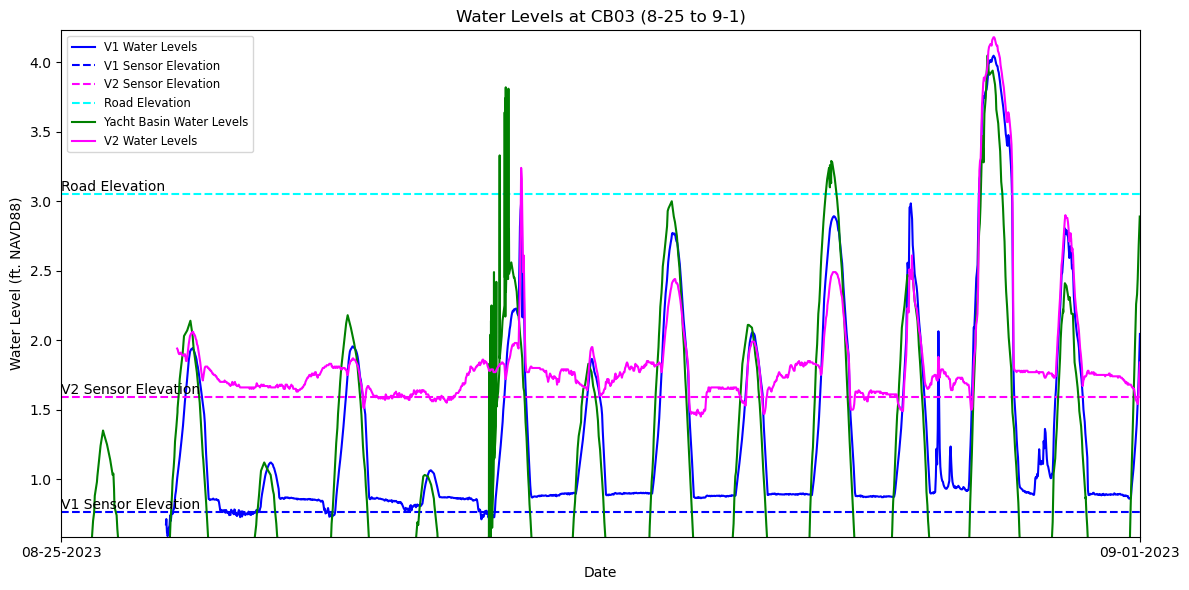

In [109]:
# Define start and end dates
start0 = datetime(2023, 8, 25)
end0 = datetime(2023, 9, 1)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = v2_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start0, end0])
plt.xticks([start0, end0])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start0, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start0, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start0, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (8-25 to 9-1)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 8-25 to 9-1.jpg"
plt.savefig(save_path)


## V2 Water Levels 9/1 to 9/8

In [110]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20230901_20230908.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-09-01 00:02:00-04:00,2.17
2023-09-01 00:08:00-04:00,2.08
2023-09-01 00:09:00-04:00,2.07
2023-09-01 00:14:00-04:00,2.05
2023-09-01 00:20:00-04:00,2.05
...,...
2023-09-07 23:32:00-04:00,1.65
2023-09-07 23:38:00-04:00,1.65
2023-09-07 23:44:00-04:00,1.65


## Plotting 9/1/23 - 9/8/23

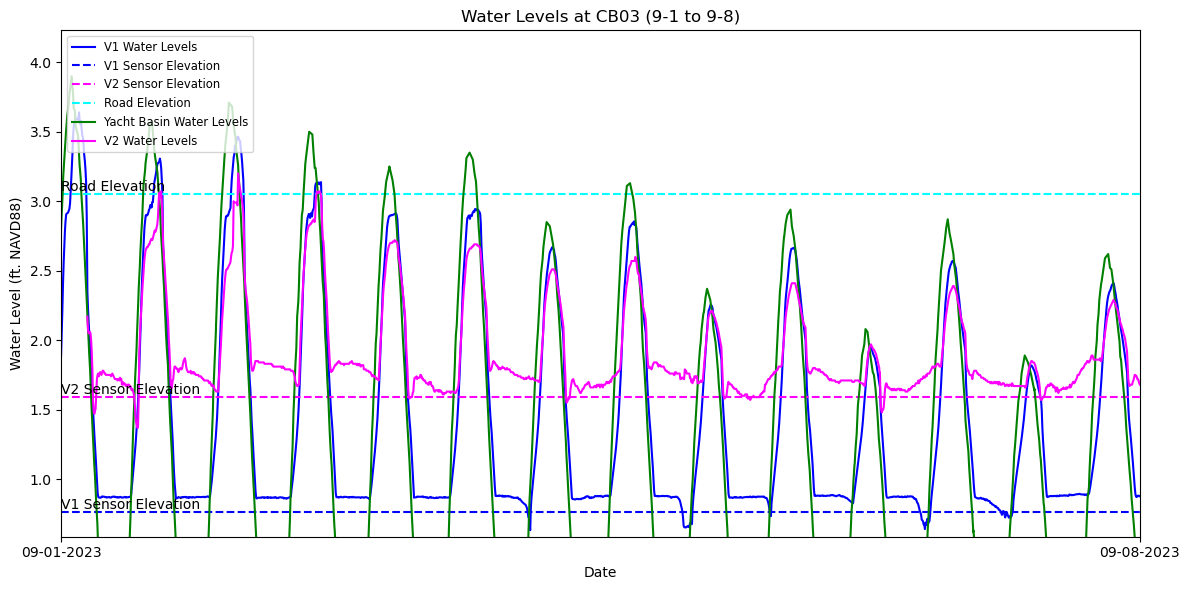

In [111]:
# Define start and end dates
start1 = datetime(2023, 9, 1)
end1 = datetime(2023, 9, 8)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = yb_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start1, end1])
plt.xticks([start1, end1])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start1, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start1, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start1, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (9-1 to 9-8)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 9-1 to 9-8.jpg"
plt.savefig(save_path)


## V2 Waterlevels 9/8 to 9/15

In [112]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20230908_20230915.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-09-08 00:02:00-04:00,1.65
2023-09-08 00:08:00-04:00,1.65
2023-09-08 00:14:00-04:00,1.66
2023-09-08 00:20:00-04:00,1.66
2023-09-08 00:26:00-04:00,1.65
...,...
2023-09-14 23:32:00-04:00,1.82
2023-09-14 23:38:00-04:00,1.81
2023-09-14 23:44:00-04:00,1.75


## Plotting 9/8/23 to 9/15/23

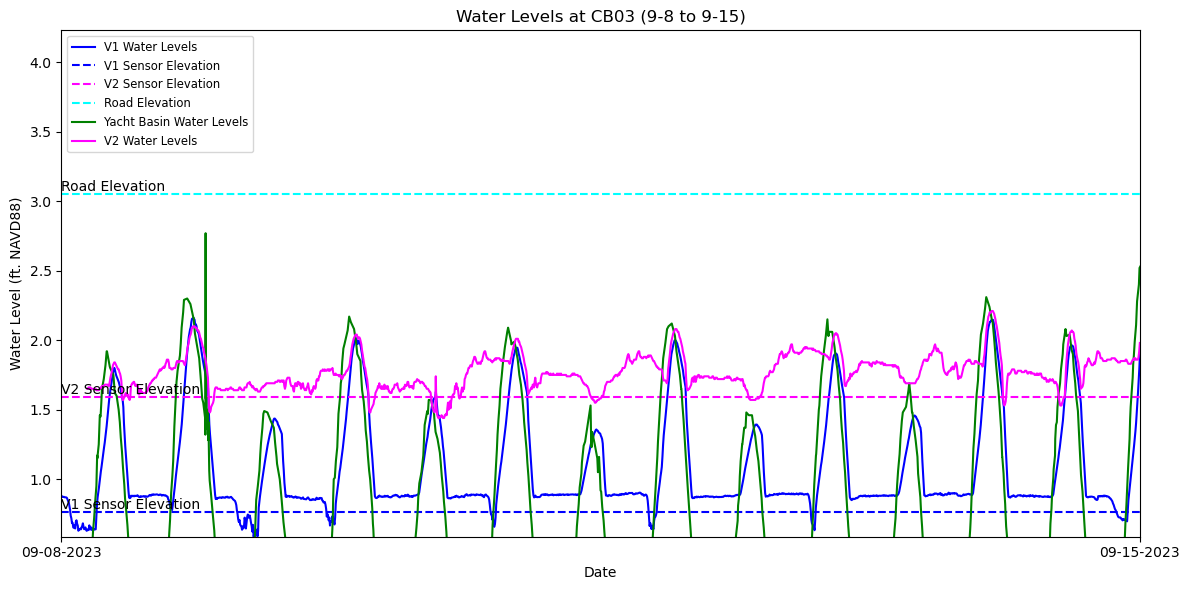

In [113]:
# Define start and end dates
start2 = datetime(2023, 9, 8)
end2 = datetime(2023, 9, 15)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = yb_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start2, end2])
plt.xticks([start2, end2])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start2, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start2, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start2, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (9-8 to 9-15)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 9-8 to 9-15.jpg"
plt.savefig(save_path)


## V2 Water Levels 9/15 to 9/22

In [114]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20230915_20230922.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-09-15 00:02:00-04:00,1.45
2023-09-15 00:08:00-04:00,1.44
2023-09-15 00:14:00-04:00,1.45
2023-09-15 00:20:00-04:00,1.49
2023-09-15 00:26:00-04:00,1.62
...,...
2023-09-21 23:32:00-04:00,1.71
2023-09-21 23:38:00-04:00,1.70
2023-09-21 23:44:00-04:00,1.70


## Plotting 9/15/23 to 9/22/23

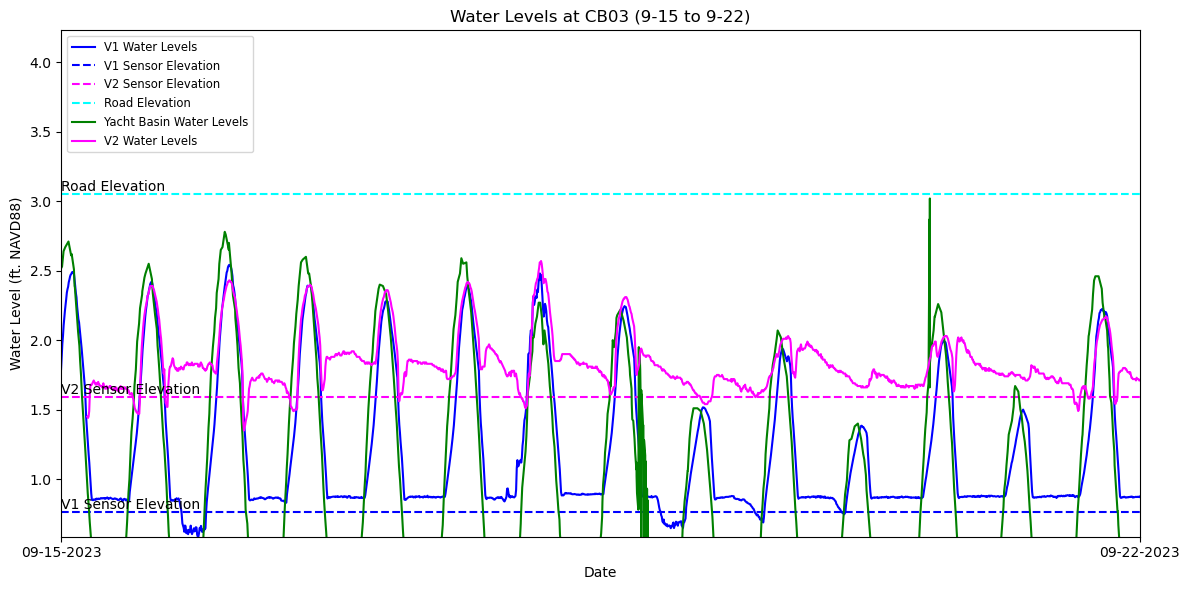

In [115]:
# Define start and end dates
start3 = datetime(2023, 9, 15)
end3 = datetime(2023, 9, 22)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = yb_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start3, end3])
plt.xticks([start3, end3])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start3, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start3, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start3, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (9-15 to 9-22)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 9-15 to 9-22.jpg"
plt.savefig(save_path)


## V2 Water Levels 9/22 to 9/29 

In [116]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20230922_20230929.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-09-22 00:02:00-04:00,1.70
2023-09-22 00:08:00-04:00,1.69
2023-09-22 00:14:00-04:00,1.69
2023-09-22 00:20:00-04:00,1.69
2023-09-22 00:26:00-04:00,1.69
...,...
2023-09-28 23:32:00-04:00,2.28
2023-09-28 23:38:00-04:00,2.21
2023-09-28 23:44:00-04:00,2.13


## Plotting 9/22/23 to 9/29/23

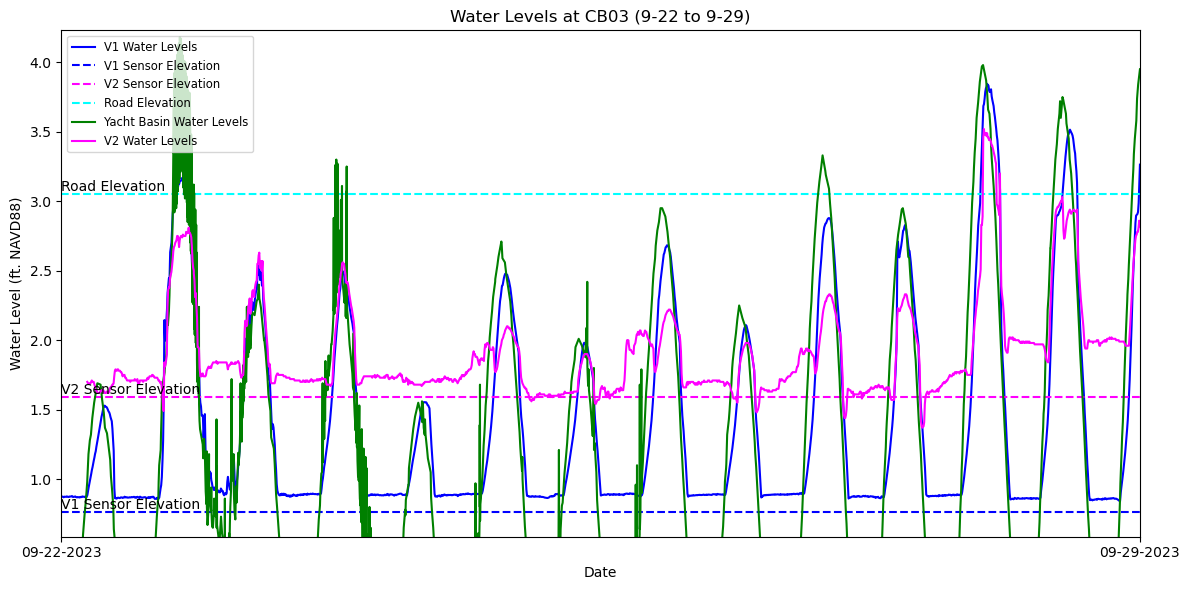

In [117]:
# Define start and end dates
start4 = datetime(2023, 9, 22)
end4 = datetime(2023, 9, 29)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = yb_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start4, end4])
plt.xticks([start4, end4])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start4, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start4, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start4, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (9-22 to 9-29)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 9-22 to 9-29.jpg"
plt.savefig(save_path)


## V2 Water Levels 9/29 to 10/6

In [118]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20230929_20231006.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-09-29 00:02:00-04:00,1.95
2023-09-29 00:08:00-04:00,1.94
2023-09-29 00:14:00-04:00,1.94
2023-09-29 00:20:00-04:00,1.97
2023-09-29 00:26:00-04:00,1.98
...,...
2023-10-05 23:31:00-04:00,1.70
2023-10-05 23:37:00-04:00,1.70
2023-10-05 23:43:00-04:00,1.70


## Plotting 9/29/23 to 10/6/23

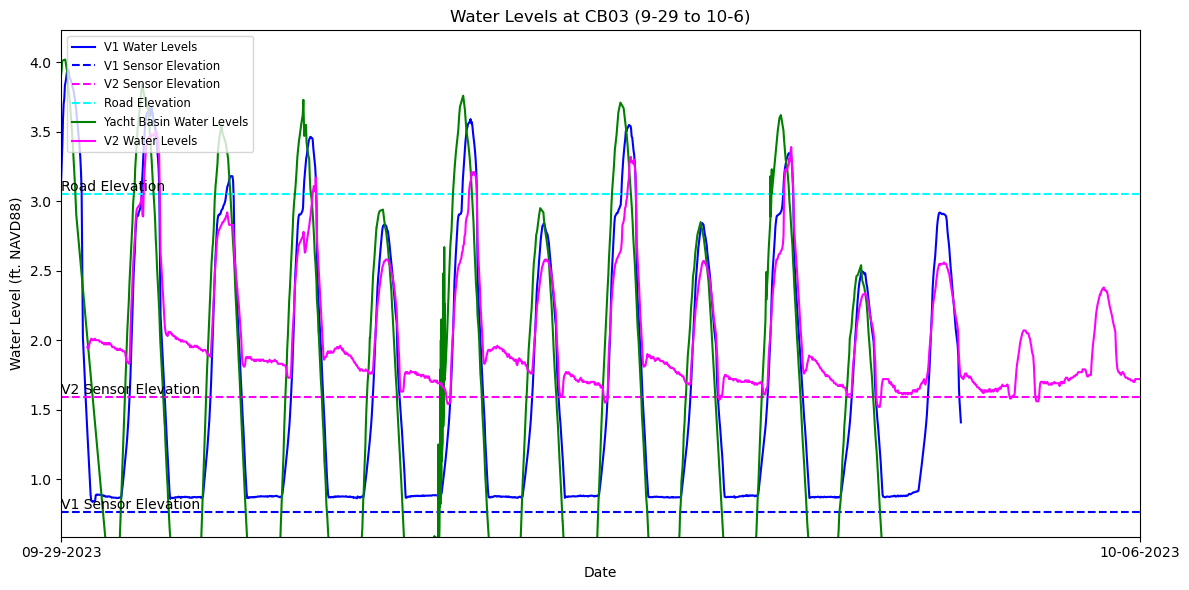

In [119]:
# Define start and end dates
start5 = datetime(2023, 9, 29)
end5 = datetime(2023, 10, 6)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = yb_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start5, end5])
plt.xticks([start5, end5])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start5, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start5, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start5, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (9-29 to 10-6)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 9-29 to 10-6.jpg"
plt.savefig(save_path)


## V2 Water Levels 10/6 to 10/13

In [120]:
# Location of files to be processed

data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison"

# Read file into a dataframe
file_path = data_location + '\\CB_03_20231006_20231013.csv'
v2_waterlevels = pd.read_csv(file_path)


# Drop specified columns from total_data
columns_to_drop2 = ['sensor elev. (ft NAVD88)', 'road elev. (ft NAVD88)', 'water level (ft above or below road elev.)']
v2_waterlevels = v2_waterlevels.drop(columns=columns_to_drop2)

# Rename columns
v2_waterlevels = v2_waterlevels.rename(columns={'timestamp (UTC)' : 'Date_Time', 'water level (ft NAVD88)' : 'Water Level (ft. NAVD88)'})

# Assuming 'Date_Time' column is already in UTC timezone
# Convert the 'Date_Time' column to a pandas datetime format if it's not already
v2_waterlevels['Date_Time'] = pd.to_datetime(v2_waterlevels['Date_Time'])

# Localize the 'Date_Time' column to UTC timezone
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_localize('UTC')

# Convert UTC to EDT
edt_timezone = pytz.timezone('America/New_York')
v2_waterlevels['Date_Time'] = v2_waterlevels['Date_Time'].dt.tz_convert(edt_timezone)


# Set Datetime column as index
v2_waterlevels.set_index('Date_Time', inplace=True)

# Sort dates and times into ascending order
v2_waterlevels = v2_waterlevels.sort_values(by='Date_Time')




v2_waterlevels

,Water Level (ft. NAVD88)
Date_Time,
2023-10-06 00:01:00-04:00,1.70
2023-10-06 00:07:00-04:00,1.69
2023-10-06 00:13:00-04:00,1.69
2023-10-06 00:19:00-04:00,1.70
2023-10-06 00:25:00-04:00,1.70
...,...
2023-10-12 11:31:00-04:00,1.81
2023-10-12 11:37:00-04:00,1.81
2023-10-12 11:43:00-04:00,1.80


## Plotting 10/6/23 to 10/13/23

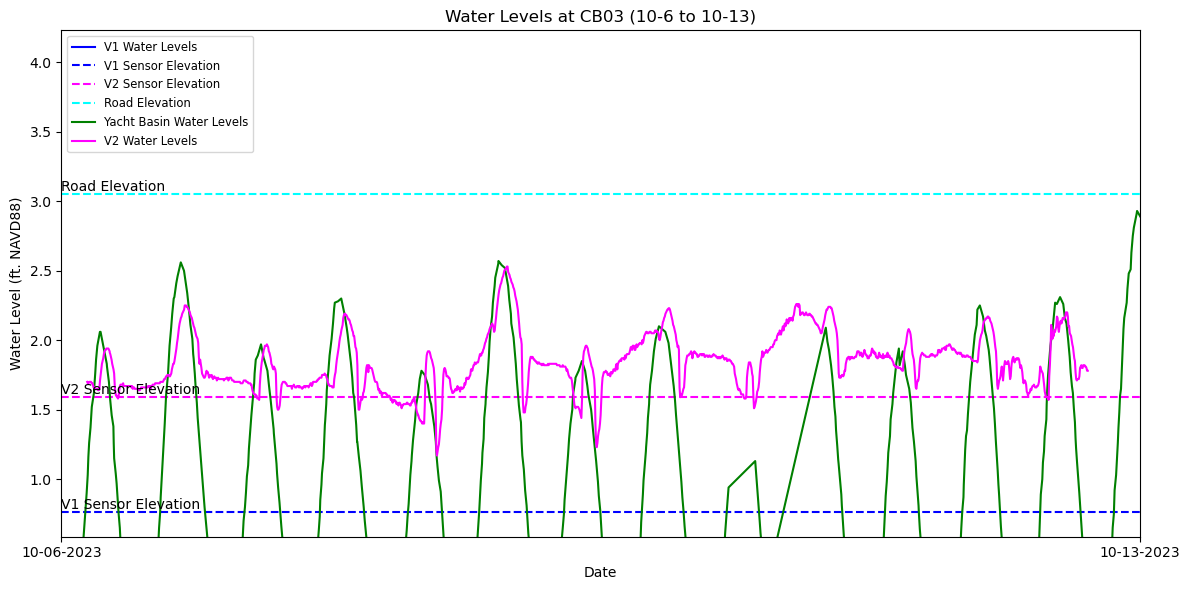

In [121]:
# Define start and end dates
start6 = datetime(2023, 10, 6)
end6 = datetime(2023, 10, 13)

# Calculate y-axis limits
y_min = combined_data['Water Level (ft. NAVD88)'].min()
y_max = yb_waterlevels['Water Level (ft. NAVD88)'].max() + .05
y_lim = (y_min, y_max)


# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

plt.plot(combined_data.index, combined_data['Water Level (ft. NAVD88)'], color='blue', label='V1 Water Levels')

# Set x-axis limits and labels
plt.xlim([start6, end6])
plt.xticks([start6, end6])
plt.xlabel('Date')
plt.ylabel('Water Level (ft. NAVD88)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))

# Set y-axis limits
plt.ylim(y_lim)

# Add horizontal lines
plt.axhline(y=0.76, color='blue', linestyle='--', label='V1 Sensor Elevation')
plt.axhline(y=1.59, color='magenta', linestyle='--', label='V2 Sensor Elevation')
plt.axhline(y=3.05, color='cyan', linestyle='--', label='Road Elevation')

# Add Labels to horizontal lines directly above the lines
plt.text(start6, .76, 'V1 Sensor Elevation ', color='black', ha='left', va='bottom')
plt.text(start6, 3.05, 'Road Elevation', color='black', ha='left', va='bottom')
plt.text(start6, 1.59, 'V2 Sensor Elevation', color='black', ha='left', va='bottom')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')


# Plot yacht basin water levels 
plt.plot(yb_waterlevels.index, yb_waterlevels['Water Level (ft. NAVD88)'], color='green', label= 'Yacht Basin Water Levels')

# Plot V2 water levels 
plt.plot(v2_waterlevels.index, v2_waterlevels['Water Level (ft. NAVD88)'], color='magenta', label = 'V2 Water Levels')

# Add overall legend
plt.legend(fontsize='small', loc='upper left')

plt.title('Water Levels at CB03 (10-6 to 10-13)')



# Adjust layout
plt.tight_layout()

#Save the plot in a specified location 
save_path = r"C:\Users\pawoo\OneDrive\Documents\Coastal Hazards Lab Stuff\Research Project Items and Python\SDF\Project Versions\CB03 Comparison\Initial CB03 V1 and V2 Comparison Plots\Plot 10-6 to 10-13.jpg"
plt.savefig(save_path)
